In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import special

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install -U git+https://github.com/tensorflow/privacy


In [ ]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

In [ ]:
num_classes = 10
def test_model():
  
  # compile model
  #opt = SGD(lr=0.001, momentum=0.9)
  #model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  shape = (32, 32, 3)
  i = Input(shape=shape)
  weight_decay = 1e-4
  #model = Sequential()
  x = Conv2D(32, (3,3), activation = 'elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=train_data.shape[1:])(i)
  #model.add(Activation('elu'))
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), activation = 'elu', padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
  #model.add(Activation('elu'))
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.2)(x)
 
  x = Conv2D(64, (3,3), activation = 'elu',padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
  #model.add(Activation('elu'))
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), activation = 'elu',padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
  #model.add(Activation('elu'))
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.3)(x)
 
  x = Conv2D(128, (3,3), activation = 'elu',padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
  #model.add(Activation('elu'))
  x = BatchNormalization()(x)
  x = Conv2D(128, (3,3), activation = 'elu',padding='same', kernel_regularizer=regularizers.l2(weight_decay))(x)
  #model.add(Activation('elu'))
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2,2))(x)
  x = Dropout(0.4)(x)
 
  x = Flatten()
  #x = Dense(num_classes, activation='softmax'))
  x = tf.keras.layers.Dense(num_classes)(x)
  model = Model(i, x)
  return model

In [ ]:
def load_cifar10():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing CIFAR10 dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.cifar10.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # cifar10 labels come one-hot encoded, there
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels
 
def make_simple_model():
  """ Define a Keras model without much of regularization
  Such a model is prone to overfitting"""
  shape = (32, 32, 3)
  i = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(i)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  # if we don't specify an activation for the last layer, we can have the logits
  x = Dense(10)(x)
  model = Model(i, x)
  return model

In [ ]:
train_data, train_labels, test_data, test_labels = load_cifar10()

170508288/170498071 [==============================] - 2s 0us/step


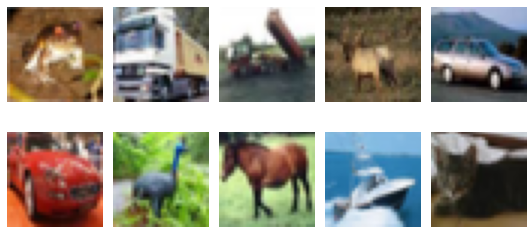

In [ ]:
# show some train data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(train_data[i])

plt.tight_layout()
plt.show()

In [ ]:
# make the neural network model with the function specified above.
# one model is supposed to train for 10, one for 50 epochs
#model = test_model()
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [ ]:
# specify parameters
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=32, 
                       epochs=30)

Epoch 1/30
1563/1563 [==============================] - 23s 9ms/step - loss: 1.5319 - accuracy: 0.4421 - val_loss: 1.2410 - val_accuracy: 0.5599
Epoch 2/30
1563/1563 [==============================] - 13s 8ms/step - loss: 1.1680 - accuracy: 0.5854 - val_loss: 1.1002 - val_accuracy: 0.6107
Epoch 3/30
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0171 - accuracy: 0.6424 - val_loss: 1.0216 - val_accuracy: 0.6446
Epoch 4/30
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9157 - accuracy: 0.6807 - val_loss: 0.9617 - val_accuracy: 0.6641
Epoch 5/30
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8453 - accuracy: 0.7040 - val_loss: 0.9107 - val_accuracy: 0.6882
Epoch 6/30
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7871 - accuracy: 0.7240 - val_loss: 0.9263 - val_accuracy: 0.6814
Epoch 7/30
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7378 - accuracy: 0.7413 - val_loss: 0.8662 - val_ac

(0.0, 1.0)

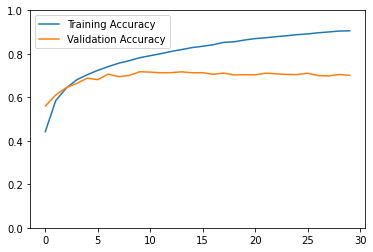

In [ ]:
# plot accuracy for the first model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend();
plt.ylim(0,1)

### Attack on the model

In [ ]:
# since we have not specified an activation function on the last layer
# calling the predict function returns the logits
print('Predict on train...')
logits_train = model.predict(train_data)
print('Predict on test...')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits...')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predict on train...
Predict on test...
Apply softmax to get probabilities from logits...
Compute losses...


In [ ]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

In [ ]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [ ]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
]

In [ ]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [ ]:
# summary by data slice (the best performing attacks per slice are presented)
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 2987 training and 2987 test examples) achieved an AUC of 0.80 on slice CORRECTLY_CLASSIFIED=False
  LOGISTIC_REGRESSION (with 2987 training and 2987 test examples) achieved an advantage of 0.47 on slice CORRECTLY_CLASSIFIED=False

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 10000 training and 10000 test examples) achieved an AUC of 0.63
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an advantage of 0.22

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.65
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 0.25

Best-performing attacks over slice: "CLASS=1"
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an AUC of 0.63
  LOGISTIC_REGRESSION (with 1000 training and 1000 test examples) achieved an advantage of 

Figure(432x288)


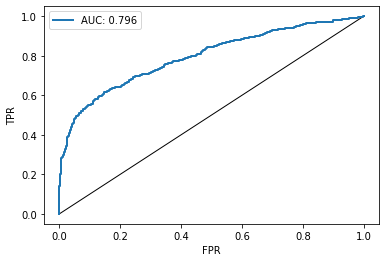

In [ ]:
# plot the curve, we see that the attacker is much better than random guessing
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))

In [ ]:
from tensorflow_privacy import compute_dp_sgd_privacy

In [ ]:
d = 1e-5
bs = 32
while bs<129:
  print("Batch Size =",bs)
  compute_dp_sgd_privacy(n=50000, batch_size=bs, noise_multiplier=0.7, epochs=30, delta=d)
  bs = bs*2

Batch Size = 32
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.7 iterated over 46875 steps satisfies differential privacy with eps = 2.19 and delta = 1e-05.
The optimal RDP order is 6.0.
Batch Size = 64
DP-SGD with sampling rate = 0.128% and noise_multiplier = 0.7 iterated over 23438 steps satisfies differential privacy with eps = 2.98 and delta = 1e-05.
The optimal RDP order is 5.0.
Batch Size = 128
DP-SGD with sampling rate = 0.256% and noise_multiplier = 0.7 iterated over 11719 steps satisfies differential privacy with eps = 4.03 and delta = 1e-05.
The optimal RDP order is 4.5.


In [ ]:
nm = 0.3
while nm<1.0:
  print("Noise Multiplier =",nm)
  compute_dp_sgd_privacy(n=50000, batch_size=32, noise_multiplier=nm, epochs=30, delta=d)
  nm = nm*1.2

Noise Multiplier = 0.3
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.3 iterated over 46875 steps satisfies differential privacy with eps = 74.3 and delta = 1e-05.
The optimal RDP order is 1.25.
The privacy estimate is likely to be improved by expanding the set of orders.
Noise Multiplier = 0.36
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.36 iterated over 46875 steps satisfies differential privacy with eps = 32.4 and delta = 1e-05.
The optimal RDP order is 1.5.
Noise Multiplier = 0.432
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.432 iterated over 46875 steps satisfies differential privacy with eps = 14 and delta = 1e-05.
The optimal RDP order is 2.25.
Noise Multiplier = 0.5184
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.5184 iterated over 46875 steps satisfies differential privacy with eps = 6.39 and delta = 1e-05.
The optimal RDP order is 3.0.
Noise Multiplier = 0.62208
DP-SGD with sampling rate = 0.064% and noise_multiplier

In [ ]:
e = 10
while e<101:
  print("Number of epochs :",e)
  compute_dp_sgd_privacy(n=50000, batch_size=32, noise_multiplier=0.8, epochs=e, delta=d)
  e = e+10

Number of epochs : 10
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 15625 steps satisfies differential privacy with eps = 1.26 and delta = 1e-05.
The optimal RDP order is 9.0.
Number of epochs : 20
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 31250 steps satisfies differential privacy with eps = 1.42 and delta = 1e-05.
The optimal RDP order is 8.0.
Number of epochs : 30
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 46875 steps satisfies differential privacy with eps = 1.52 and delta = 1e-05.
The optimal RDP order is 8.0.
Number of epochs : 40
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 62500 steps satisfies differential privacy with eps = 1.62 and delta = 1e-05.
The optimal RDP order is 8.0.
Number of epochs : 50
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 78125 steps satisfies differential privacy with eps = 1.72 and delta = 1e-05.


In [ ]:
delta = 1e-4
while delta>1e-7:
  print("Privacy Budegt: ",delta)
  compute_dp_sgd_privacy(n=50000, batch_size=32, noise_multiplier=0.8, epochs=e, delta=delta)
  delta = delta*(1e-1)

Privacy Budegt:  0.0001
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 171875 steps satisfies differential privacy with eps = 2 and delta = 0.0001.
The optimal RDP order is 8.0.
Privacy Budegt:  1e-05
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 171875 steps satisfies differential privacy with eps = 2.32 and delta = 1e-05.
The optimal RDP order is 8.0.
Privacy Budegt:  1.0000000000000002e-06
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 171875 steps satisfies differential privacy with eps = 2.65 and delta = 1.0000000000000002e-06.
The optimal RDP order is 8.0.
Privacy Budegt:  1.0000000000000002e-07
DP-SGD with sampling rate = 0.064% and noise_multiplier = 0.8 iterated over 171875 steps satisfies differential privacy with eps = 2.98 and delta = 1.0000000000000002e-07.
The optimal RDP order is 8.0.
